# Meta-Learning with the Rank-Weighted GP Ensemble (RGPE)
Botorch is designed in to be model-agnostic and only requries that a model conform to a minimal interface. This tutorial walks through an example of implementing the rank-weighted Gaussian process ensemble (RGPE) [Feurer, Letham, Bakshy ICML 2018 AutoML Workshop] and using the RGPE in botorch to do meta-learning across related optimization tasks.

* Original paper: https://arxiv.org/pdf/1802.02219.pdf

In [1]:
import torch
import math

from torch import Tensor

torch.manual_seed(29)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cuda:4")
dtype = torch.float
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

## Toy Problem
* We consider optimizing the following 1-D synthetic function
$$f(x, s_i) = \frac{1}{10}\bigg(x-1\bigg)\bigg(\sin(x+s_i)+\frac{1}{10}\bigg)$$
where
$$s_i = \frac{(i+9)\pi}{8}$$
is a task-dependent shift parameter and $i$ is the task index $i \in [1, t]$.

* In this tutorial, we will consider the scenario where we have collected data from 5 prior tasks (referred to as base tasks), which with a different task dependent shift parameter $s_i$.

* The goal now is use meta-learning to improve sample efficiency when optimizing a 6th task.

### Toy Problem Setup

First let's define a function for compute the shift parameter $s_i$ and set the shift amount for the target task.

In [3]:
NUM_BASE_TASKS = 5
def task_shift(task):
    """
    Fetch shift amount for task.
    """
    return math.pi * (task + 9) / 8.0
# set shift for target task
TARGET_SHIFT = math.pi

Then, let's define our function $f(x, s_i)$ and set bounds on $x$.

In [4]:
BOUNDS = torch.tensor([[-10.0], [10.0]], dtype=dtype, device=device)

def f(X: Tensor, shift: float = TARGET_SHIFT) -> Tensor:
    """
    Torch-compatible objective function for the target_task
    """
    f_X = 0.1*(X-1) * (torch.sin(X + shift) + 0.1)
    return f_X

### Sample training data for prior base tasks

We sample data from a Sobol sequence to help ensure numerical stability when using a small amount of 1-D data. Sobol sequences help prevent us from sampling a bunch of training points that are close together.

In [7]:
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
# Sample data for each base task
data_by_task = {}
for task in range(NUM_BASE_TASKS):
    num_training_points = torch.randint(low=15, high=26, size=(1,)).item()
    # draw points from a sobol sequence
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=num_training_points, q=1, seed=task+5397923).squeeze(1)    
    # get observed values
    train_y = f(raw_x, task_shift(task)).view(-1)
    # store training data
    data_by_task[task] = {
        # scale x to [0, 1]
        'train_x': normalize(raw_x, bounds=BOUNDS),
        'train_y': train_y,
    }         

#### Let's plot the base tasks and the target task function along with the observed points

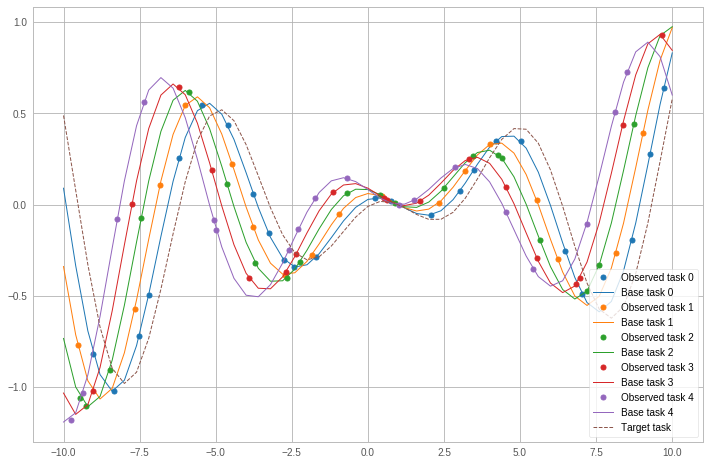

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = torch.linspace(-10,10,51)
for task in data_by_task:
    # plot true function and observed values for base runs
    t = ax.plot(
        unnormalize(data_by_task[task]['train_x'], bounds=BOUNDS).cpu().numpy(),
        data_by_task[task]['train_y'].cpu().numpy(),
        '.',
        markersize=10,
        label=f"Observed task {task}",
    )
    ax.plot(
        x.detach().numpy(),
        f(x, task_shift(task)).cpu().numpy(),
        label=f"Base task {task}",
        color=t[0].get_color(), 
    )
# plot true target function
ax.plot(
    x.detach().numpy(),
    f(x, TARGET_SHIFT).detach().numpy(),
    '--',
    label="Target task",

)
ax.legend(loc="lower right", fontsize=10)

### Fit base task models

First, let's define a helper function to fit a SingleTaskGP with an inferred noise level given training data.

In [9]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_torch

def get_fitted_model(train_X: Tensor, train_Y: Tensor) -> SingleTaskGP:
    """
    Fit SingleTaskGP with torch.optim.Adam.
    """
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model).to(train_X)
    model.train()
    model.likelihood.train()
    fit_torch(mll)
    model.eval()
    model.likelihood.eval()
    return model

#### Now let's fit a SingleTaskGP for each base task

In [10]:
# Fit base model
base_model_list = []
for task in range(NUM_BASE_TASKS):
    print(f"Fitting base model {task}")
    model = get_fitted_model(data_by_task[task]['train_x'], data_by_task[task]['train_y'])
    base_model_list.append(model)  

Fitting base model 0
Iter 1/100: 1.2367362976074219
Iter 11/100: 1.084855556488037
Iter 21/100: 0.9562214612960815
Iter 31/100: 0.8621876239776611
Iter 41/100: 0.8093296885490417
Iter 51/100: 0.7112823724746704
Iter 61/100: 0.5731977224349976
Iter 71/100: 0.41758662462234497
Iter 81/100: 0.29014837741851807
Iter 91/100: 0.18268752098083496
Iter 100/100: 0.08190318942070007
Fitting base model 1
Iter 1/100: 1.343477725982666
Iter 11/100: 1.174939513206482
Iter 21/100: 1.027818202972412
Iter 31/100: 0.902186930179596
Iter 41/100: 0.8259419798851013
Iter 51/100: 0.8019661903381348
Iter 61/100: 0.7998809218406677
Iter 71/100: 0.7981947660446167
Iter 81/100: 0.7907634377479553
Iter 91/100: 0.7679137587547302
Iter 100/100: 0.7277565598487854
Fitting base model 2
Iter 1/100: 1.319837212562561
Iter 11/100: 1.162716269493103
Iter 21/100: 1.0373553037643433
Iter 31/100: 0.9445716142654419
Iter 41/100: 0.8936354517936707
Iter 51/100: 0.8166782259941101
Iter 61/100: 0.7046409845352173
Iter 71/100: 

### Plot base models

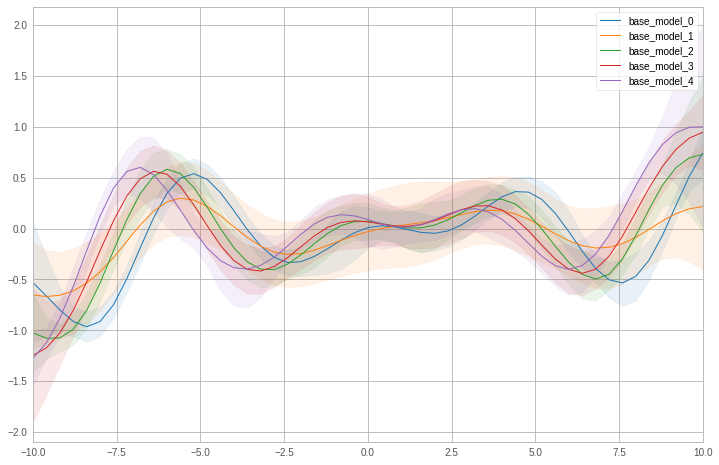

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Test points are regularly spaced along [-10, 10]
test_x = torch.linspace(-10, 10, 51, dtype=dtype, device=device)
for task in range(NUM_BASE_TASKS):
    model = base_model_list[task]
    # compute posterior (without gradients)
    with torch.no_grad():
        posterior = model.posterior(normalize(test_x, bounds=BOUNDS))
    # compute 95% confidence intervals
    lower, upper = posterior.mvn.confidence_region()
    t = ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), label=f'base_model_{task}')
    ax.fill_between(
        test_x.cpu().numpy(), 
        lower.detach().cpu().numpy(), 
        upper.detach().cpu().numpy(), 
        color=t[0].get_color(), 
        alpha=0.1,
        
    )
ax.set_xlim([-10, 10])
ax.legend(fontsize=10)


### Implement the RGPE

The main idea of the RGPE is to estimate the target function as weighted sum of the target model and the base models:
$$\bar f(\mathbf x | \mathcal D) =
\sum_{i=1}^{t} w_if^i(\mathbf x |\mathcal D_i)$$
Importantly, the ensemble model is also a GP:
$$\bar f(\mathbf x | \mathcal D) \sim \mathcal N\bigg(\sum_{i=1}^{t} w_i\mu_i(\mathbf x), \sum_{i=1}^{t}w_i^2\sigma_i^2\bigg)$$

The weights $w_i$ for model $i$ are based on the the ranking loss between a draw from the model's posterior and the targets. Specifically, the ranking loss for model $i$ is:
$$\mathcal L(f^i, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^i\big(\mathbf x^t_j\big) < f^i\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $\oplus$ is exclusive-or.

The loss for the target model is computing using leave-one-out cross-validation (LOOCV) and is given by:
$$\mathcal L(f^t, \mathcal D_t) = \sum_{j=1}^{n_t}\sum_{k=1}^{n_t}\mathbb 1\bigg[\bigg(f^t_{-j}\big(\mathbf x^t_j\big) < f^t_{-j}\big(\mathbf x_k^t\big)\bigg)\oplus \big(y_j^t < y_k^t\big)\bigg]$$
where $f^t_{-j}$ model fitted to all data from the target task except training example $j$.

The weights are then computed as:
$$w_i = \frac{1}{S}\sum_{s=1}^S\mathbb 1\big(i = \text{argmin}_{i'}l_{i', s}\big)$$

In [12]:
def roll_col(X: Tensor, shift: int) -> Tensor:  
    """
    Rotate columns to right by shift.
    """
    return torch.cat((X[:, -shift:], X[:, :-shift]), dim=1)


In [13]:
def compute_ranking_loss(f_samps: Tensor, target_y: Tensor) -> Tensor:
    """
    Compute ranking loss for each sample from the posterior over target points.
    
    Args:
        f_samps: `n_samples x n`-dim tensor of samples
        target_y: `n`-dim tensor of targets
    Returns:
        Tensor: `n_samples`-dim tensor containing the ranking loss across each sample
    """
    y_stack = target_y.expand(f_samps.shape[0], *target_y.shape)
    rank_loss = torch.zeros(f_samps.shape[0], dtype=torch.long, device=target_y.device)
    for i in range(1,target_y.shape[0]):
        rank_loss += torch.sum(
            (roll_col(f_samps, i) < f_samps) ^ (roll_col(y_stack, i) < y_stack), 
            dim=1
        )
    return rank_loss


Defin a function to do use LOOCV to fit `n` independent GPs (using batch mode) and sample from their posterior at their respective test point. Note one deviation from the original paper is that the kernel hyperparameters are refit for each fold of the LOOCV, whereas the paper uses kernel hyperparameters from the original target model fit on all data points. 

Check out the [gpytorch batch mode fitting tutorial](https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Simple_GP_Regression/Simple_Batch_Mode_GP_Regression.ipynb) for more info on batch mode GPs.

In [14]:
def get_target_model_loocv_sample_preds(train_x: Tensor, train_y: Tensor, num_samples: int) -> Tensor:
    """
    Use LOOCV to fit `b=n` independent GPs using batch mode and sample from
        their independent posteriors.
    
    Args:
        train_x: `n x d` tensor of training points
        train_y: `n` tensor of training targets
        num_sample: number of mc samples to draw
    
    Return: `num_samples x n`-dim tensor of samples for each target point from the corresponding GP
        (which was training without that point).
    """
    train_x = train_x.view(-1, 1)
    train_y = train_y.view(-1)
    batch_size = len(train_x)
    masks = torch.eye(len(train_x), dtype=torch.uint8)
    train_x_cv = torch.stack([train_x[~m] for m in masks])
    train_y_cv = torch.stack([train_y[~m] for m in masks])
    test_x_cv = torch.stack([train_x[m] for m in masks])
    test_y_cv = torch.stack([train_y[m] for m in masks])
    print("Fitting target model with LOOCV")
    model = get_fitted_model(train_x_cv, train_y_cv)
    with torch.no_grad():
        # test_x_cv here is `n (batch dimension) x 1 (num points) x 1 (num dimensions)`.
        posterior = model.posterior(test_x_cv)
        # Since we have a batch mode gp and model.posterior always returns an output dimension,
        # the output from `posterior.sample()` here `num_samples x n x 1 x 1`, so let's squeeze
        # the last two dimensions.
        return posterior.sample(sample_shape=torch.Size((num_samples,))).squeeze(-1).squeeze(-1)
    

In [15]:
from typing import List

def compute_rank_weights(
    train_x: Tensor, 
    train_y: Tensor, 
    base_models: List[SingleTaskGP], 
    num_samples: int
) -> Tensor:
    """
    Compute ranking weights for each base model and the target model (using 
        LOOCV for the target model). Note: This implementation does not currently 
        address weight dilution, since we only have a small number of base models.
    
    Args:
        train_x: `n x d` tensor of training points (for target task)
        train_y: `n` tensor of training targets (for target task)
        base_models: list of `n_t` base models
        num_samples: number of mc samples
    
    Returns:
        Tensor: `n_t`-dim tensor with the ranking weight for each model
    """
    ranking_losses = []
    # compute ranking loss for each base model
    for task in range(len(base_models)):
        model = base_models[task]
        # compute posterior over training points for target task
        posterior = model.posterior(train_x)
        f_samps = posterior.sample(sample_shape=torch.Size((num_samples,))).squeeze(-1).squeeze(-1)
        # compute and save ranking loss
        ranking_losses.append(compute_ranking_loss(f_samps, train_y))
    # compute ranking loss for target model using LOOCV
    f_samps = get_target_model_loocv_sample_preds(train_x, train_y, num_samples)
    ranking_losses.append(compute_ranking_loss(f_samps, train_y))
    ranking_loss_tensor = torch.stack(ranking_losses)
    # compute best model (minimum ranking loss) for each sample
    best_models = torch.argmin(ranking_loss_tensor, dim=0)
    # compute proportion of samples for which each model is best
    rank_weights = best_models.bincount(minlength=len(ranking_losses)).type_as(train_x)/num_samples
    return rank_weights
        

In [16]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.models import GP
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import LikelihoodList
from torch.nn import ModuleList

class RGPE(GP, GPyTorchModel):
    """
    Rank-weighted GP ensemble. Note: this class inherits from GPyTorchModel which provides an 
        interface for GPyTorch models in botorch.
    """
    def __init__(self, models: List[SingleTaskGP], weights: Tensor) -> None:
        super().__init__()
        self.models = ModuleList(models)
        for m in models:
            if not hasattr(m, "likelihood"):
                raise ValueError(
                    "RGPE currently only supports models that have a likelihood (e.g. ExactGPs)"
                )
        self.likelihood = LikelihoodList(*[m.likelihood for m in models])
        self.weights = weights
        self.to(dtype=weights.dtype, device=weights.device)
    
    @property
    def num_outputs(self) -> int:
        return 1
        
    def forward(self, x: Tensor) -> MultivariateNormal:
        # compute posterior for each model
        posteriors = [model.posterior(x) for model in self.models]
        weighted_means = []
        weighted_covars = []
        
        # filter model with zero weights
        # weights on covariance matrices are weight**2
        non_zero_weight_indices = (self.weights**2 > 0).nonzero()
        non_zero_weights = self.weights[non_zero_weight_indices]
        # re-normalize
        non_zero_weights /= non_zero_weights.sum()
        
        for non_zero_weight_idx in range(non_zero_weight_indices.shape[0]):
            raw_idx = non_zero_weight_indices[non_zero_weight_idx].item()
            posterior = posteriors[raw_idx]
            weight = non_zero_weights[non_zero_weight_idx]
            weighted_means.append(weight * posterior.mean.squeeze(-1))
            # Use lazy covariance matrix
            weighted_covars.append(posterior.mvn.lazy_covariance_matrix * weight**2)
        # set mean and covariance to be the rank-weighted sum the means and covariances of the
        # base models and target model
        mean_x = torch.sum(torch.stack(weighted_means), dim=0)
        covar_x = gpytorch.lazy.PsdSumLazyTensor(*weighted_covars)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    

## Optimize target function using RGPE + mc-based qEI

In [ ]:
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.sampler import SobolQMCNormalSampler
from botorch.optim.optimize import joint_optimize
import pandas as pd

best_rgpe_all = []
best_random_all = []
best_vanilla_ei_all = []
N_BATCH = 10
INNER_OPTIMIZER_LOOPS = 15
NUM_POSTERIOR_SAMPLES = 10
RANDOM_INITIALIZATION_SIZE = 4
N_TRIALS = 20
MC_SAMPLES = 1000
N_RESTART_CANDIDATES = 100
N_RESTARTS = 5
Q_BATCH_SIZE=1
# Average over multiple trials
for trial in range(N_TRIALS):
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_rgpe = []
    best_random = [] 
    best_vanilla_ei = []
    # Initial random observations
    raw_x = draw_sobol_samples(bounds=BOUNDS, n=RANDOM_INITIALIZATION_SIZE, q=1, seed=trial).squeeze(1)    
    train_x = normalize(raw_x, bounds=BOUNDS)
    train_y = f(train_x)
    vanilla_ei_train_x = train_x.clone()
    vanilla_ei_train_y = train_y.clone()
    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    best_rgpe.append(best_value)
    best_random.append(best_value)
    vanilla_ei_best_value = best_value
    best_vanilla_ei.append(vanilla_ei_best_value)


    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH): 
        print(f"Fitting target model: {iteration+1}")
        target_model = get_fitted_model(train_x, train_y.view(-1))
        model_list = base_model_list + [target_model]
        rank_weights = compute_rank_weights(train_x, train_y.view(-1), base_model_list, NUM_POSTERIOR_SAMPLES)
        print("Rank weights: {}".format(rank_weights.detach().cpu().numpy()))
        rgpe_model = RGPE(model_list, rank_weights)
        print(f"Optimizing EI: {iteration+1}")
        sampler_qei = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        qEI = qExpectedImprovement(model=model, best_f=best_value)
        candidate = joint_optimize(
            acq_function=qEI,
            bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
            options={"seed": torch.randint(1, 100000, (1,)).item()},
        )

        # fetch the new values 
        new_x = candidate.detach()
        new_y = f(unnormalize(new_x, bounds=BOUNDS))

        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        random_candidate = torch.rand(1, dtype=dtype, device=device)
        next_random_best = f(unnormalize(random_candidate, bounds=BOUNDS)).max().item()
        best_random.append(max(best_random[-1], next_random_best))

        # get the new best observed value
        best_value = train_y.max().item()
        best_rgpe.append(best_value)
        print(f"Finished iteration: {iteration+1}, best value: {best_value}")

        # Run Vanilla EI for comparison
        print(f"Running vanilla EI: {iteration+1}")
        vanilla_ei_model = get_fitted_model(vanilla_ei_train_x, vanilla_ei_train_y.view(-1))
        vanilla_ei_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        vanilla_qEI = qExpectedImprovement(
            model=vanilla_ei_model, 
            best_f=vanilla_ei_best_value, 
            sampler=vanilla_ei_sampler,
        )
        vanilla_ei_candidate = joint_optimize(
            acq_function=vanilla_qEI,
            bounds=torch.tensor([[0.],[1.]], dtype=dtype, device=device),
            q=Q_BATCH_SIZE,
            num_restarts=N_RESTARTS,
            raw_samples=N_RESTART_CANDIDATES,
            options={"seed": torch.randint(1, 100000, (1,)).item()},
        )
        # fetch the new values 
        vanilla_ei_new_x = vanilla_ei_candidate.detach()
        vanilla_ei_new_y = f(unnormalize(vanilla_ei_new_x, bounds=BOUNDS))

        # update training points
        vanilla_ei_train_x = torch.cat((vanilla_ei_train_x, vanilla_ei_new_x))
        vanilla_ei_train_y = torch.cat((vanilla_ei_train_y, vanilla_ei_new_y))

        # get the new best observed value
        vanilla_ei_best_value = vanilla_ei_train_y.max().item()
        best_vanilla_ei.append(vanilla_ei_best_value)
        print(f"Finished vanilla EI iteration: {iteration+1}, best value: {vanilla_ei_best_value}")
    best_rgpe_all.append(best_rgpe)
    best_random_all.append(best_random)
    best_vanilla_ei_all.append(best_vanilla_ei)
    

Trial 1 of 20
Fitting target model: 1
Iter 1/100: 2.7183194160461426
Iter 11/100: 2.413863182067871
Iter 21/100: 2.2172999382019043
Iter 31/100: 2.0069310665130615
Iter 41/100: 1.7813026905059814
Iter 51/100: 1.5480188131332397
Iter 61/100: 1.3096888065338135
Iter 71/100: 1.0684775114059448
Iter 81/100: 0.8262431025505066
Iter 91/100: 0.583232045173645
Iter 100/100: 0.36510443687438965
Fitting target model with LOOCV
Iter 1/100: 39.86390686035156
Iter 11/100: 35.74186706542969
Iter 21/100: 32.49754333496094
Iter 31/100: 29.594112396240234
Iter 41/100: 26.74742317199707
Iter 51/100: 24.015689849853516
Iter 61/100: 21.373680114746094
Iter 71/100: 18.785541534423828
Iter 81/100: 16.236392974853516
Iter 91/100: 13.726358413696289
Iter 100/100: 11.489255905151367
Rank weights: [0.1 0.6 0.  0.1 0.2 0. ]
Optimizing EI: 1
Finished iteration: 1, best value: 0.4790210425853729
Running vanilla EI: 1
Iter 1/100: 2.7183194160461426
Iter 11/100: 2.4144062995910645
Iter 21/100: 2.217362880706787
Iter

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Fitting target model with LOOCV
Iter 1/100: 61.59727096557617
Iter 11/100: 55.322113037109375
Iter 21/100: 49.87028503417969
Iter 31/100: 44.790565490722656
Iter 41/100: 39.98197937011719
Iter 51/100: 35.55360794067383
Iter 61/100: 31.70052146911621
Iter 71/100: 28.576353073120117
Iter 81/100: 26.326038360595703
Iter 91/100: 24.905054092407227
Iter 100/100: 24.031373977661133
Rank weights: [0.5 0.2 0.  0.  0.3 0. ]
Optimizing EI: 4
Finished iteration: 4, best value: 0.579619288444519
Running vanilla EI: 4
Iter 1/100: 1.938291072845459
Iter 11/100: 1.7012442350387573
Iter 21/100: 1.5123528242111206
Iter 31/100: 1.3122267723083496
Iter 41/100: 1.1111066341400146
Iter 51/100: 0.9200165867805481
Iter 61/100: 0.7495368123054504
Iter 71/100: 0.6033295392990112
Iter 81/100: 0.4740177094936371
Iter 91/100: 0.3543967008590698
Iter 100/100: 0.25335800647735596
Finished vanilla EI iteration: 4, best value: 0.3806784152984619
Fitting target model: 5
Iter 1/100: 1.8298436403274536
Iter 11/100: 1.59

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 68.95611572265625
Iter 11/100: 61.877044677734375
Iter 21/100: 55.657615661621094
Iter 31/100: 49.778587341308594
Iter 41/100: 44.190338134765625
Iter 51/100: 39.025909423828125
Iter 61/100: 34.477630615234375
Iter 71/100: 30.759769439697266
Iter 81/100: 28.088117599487305
Iter 91/100: 26.4146785736084
Iter 100/100: 25.459510803222656
Rank weights: [0.5 0.  0.  0.1 0.4 0. ]
Optimizing EI: 5
Finished iteration: 5, best value: 0.579619288444519
Running vanilla EI: 5
Iter 1/100: 1.800716519355774
Iter 11/100: 1.5689088106155396
Iter 21/100: 1.3766329288482666
Iter 31/100: 1.1731005907058716
Iter 41/100: 0.9644327759742737
Iter 51/100: 0.7692490220069885
Iter 61/100: 0.5935541391372681
Iter 71/100: 0.43889284133911133
Iter 81/100: 0.29618364572525024
Iter 91/100: 0.15990933775901794
Iter 100/100: 0.043202757835388184
Finished vanilla EI iteration: 5, best value: 0.3806784152984619
Fitting target model: 6
Iter 1/100: 1.7200393676757812
Iter 11/100: 1.491160273551941
Iter 21/100:

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 76.32916259765625
Iter 11/100: 68.43480682373047
Iter 21/100: 61.3927001953125
Iter 31/100: 54.68353271484375
Iter 41/100: 48.281585693359375
Iter 51/100: 42.359580993652344
Iter 61/100: 37.11930847167969
Iter 71/100: 32.79441452026367
Iter 81/100: 29.649765014648438
Iter 91/100: 27.63295555114746
Iter 100/100: 26.46411895751953
Rank weights: [0.6 0.1 0.  0.1 0.2 0. ]
Optimizing EI: 6
Finished iteration: 6, best value: 0.579619288444519
Running vanilla EI: 6
Iter 1/100: 1.6907020807266235
Iter 11/100: 1.4659510850906372
Iter 21/100: 1.2714813947677612
Iter 31/100: 1.0640143156051636
Iter 41/100: 0.8541474938392639
Iter 51/100: 0.6533072590827942
Iter 61/100: 0.47005972266197205
Iter 71/100: 0.30286920070648193
Iter 81/100: 0.14793406426906586
Iter 91/100: 0.0008652607793919742
Iter 100/100: -0.1227421760559082
Finished vanilla EI iteration: 6, best value: 0.39764705300331116
Fitting target model: 7
Iter 1/100: 1.6304939985275269
Iter 11/100: 1.4071015119552612
Iter 21/100: 

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 83.71127319335938
Iter 11/100: 75.01429748535156
Iter 21/100: 67.14155578613281
Iter 31/100: 59.65115737915039
Iter 41/100: 52.454078674316406
Iter 51/100: 45.75831604003906
Iter 61/100: 39.782379150390625
Iter 71/100: 34.78069305419922
Iter 81/100: 31.062088012695312
Iter 91/100: 28.57916259765625
Iter 100/100: 26.62075424194336
Rank weights: [0.2 0.  0.1 0.  0.7 0. ]
Optimizing EI: 7
Finished iteration: 7, best value: 0.579619288444519
Running vanilla EI: 7
Iter 1/100: 1.6030505895614624
Iter 11/100: 1.3804759979248047
Iter 21/100: 1.1863125562667847
Iter 31/100: 0.9776163101196289
Iter 41/100: 0.7684348225593567
Iter 51/100: 0.5664610266685486
Iter 61/100: 0.37804388999938965
Iter 71/100: 0.20545999705791473
Iter 81/100: 0.0433046817779541
Iter 91/100: -0.10593652725219727
Iter 100/100: -0.23389123380184174
Finished vanilla EI iteration: 7, best value: 0.39764705300331116
Fitting target model: 8
Iter 1/100: 1.556086540222168
Iter 11/100: 1.3364697694778442
Iter 21/100: 1

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 91.09942626953125
Iter 11/100: 81.57474517822266
Iter 21/100: 72.88724517822266
Iter 31/100: 64.61864471435547
Iter 41/100: 56.649662017822266
Iter 51/100: 49.14727783203125
Iter 61/100: 42.405479431152344
Iter 71/100: 36.68661117553711
Iter 81/100: 32.347450256347656
Iter 91/100: 29.386577606201172
Iter 100/100: 26.629127502441406
Rank weights: [0.5 0.1 0.1 0.  0.3 0. ]
Optimizing EI: 8
Finished iteration: 8, best value: 0.579619288444519
Running vanilla EI: 8
Iter 1/100: 1.5299041271209717
Iter 11/100: 1.3117107152938843
Iter 21/100: 1.1130938529968262
Iter 31/100: 0.90361088514328
Iter 41/100: 0.6908007860183716
Iter 51/100: 0.4847303330898285
Iter 61/100: 0.29146265983581543
Iter 71/100: 0.1123160719871521
Iter 81/100: -0.05541535094380379
Iter 91/100: -0.21441581845283508
Iter 100/100: -0.34882962703704834
Finished vanilla EI iteration: 8, best value: 0.39764705300331116
Fitting target model: 9
Iter 1/100: 1.4932830333709717
Iter 11/100: 1.2768161296844482
Iter 21/100:

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 98.49170684814453
Iter 11/100: 88.1313247680664
Iter 21/100: 78.60694885253906
Iter 31/100: 69.44277954101562
Iter 41/100: 60.6481819152832
Iter 51/100: 52.3763313293457
Iter 61/100: 44.89408874511719
Iter 71/100: 38.49193572998047
Iter 81/100: 33.49014663696289
Iter 91/100: 29.79808235168457
Iter 100/100: 24.656160354614258
Rank weights: [0.5 0.1 0.  0.2 0.2 0. ]
Optimizing EI: 9
Finished iteration: 9, best value: 0.579619288444519
Running vanilla EI: 9
Iter 1/100: 1.4685144424438477
Iter 11/100: 1.2520288228988647
Iter 21/100: 1.054696798324585
Iter 31/100: 0.8449094295501709
Iter 41/100: 0.630391001701355
Iter 51/100: 0.42213135957717896
Iter 61/100: 0.22493740916252136
Iter 71/100: 0.03892171382904053
Iter 81/100: -0.13730672001838684
Iter 91/100: -0.3032609224319458
Iter 100/100: -0.4457443654537201
Finished vanilla EI iteration: 9, best value: 0.39764705300331116
Fitting target model: 10
Iter 1/100: 1.439561128616333
Iter 11/100: 1.2231804132461548
Iter 21/100: 1.0302

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 105.8868408203125
Iter 11/100: 94.70110321044922
Iter 21/100: 84.35346984863281
Iter 31/100: 74.42454528808594
Iter 41/100: 64.78838348388672
Iter 51/100: 55.726112365722656
Iter 61/100: 47.41831970214844
Iter 71/100: 40.29500961303711
Iter 81/100: 34.684814453125
Iter 91/100: 30.491281509399414
Iter 100/100: 25.04611587524414
Rank weights: [0.4 0.1 0.  0.3 0.2 0. ]
Optimizing EI: 10
Finished iteration: 10, best value: 0.579619288444519
Running vanilla EI: 10
Iter 1/100: 1.4162209033966064
Iter 11/100: 1.2017014026641846
Iter 21/100: 1.0010181665420532
Iter 31/100: 0.7893869280815125
Iter 41/100: 0.5725799798965454
Iter 51/100: 0.36047613620758057
Iter 61/100: 0.15836957097053528
Iter 71/100: -0.032464586198329926
Iter 81/100: -0.21288271248340607
Iter 91/100: -0.3831920325756073
Iter 100/100: -0.5338601469993591
Finished vanilla EI iteration: 10, best value: 0.39764705300331116
Trial 2 of 20
Fitting target model: 1
Iter 1/100: 2.704674482345581
Iter 11/100: 2.3772039413452

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 61.56489181518555
Iter 11/100: 55.243194580078125
Iter 21/100: 49.728240966796875
Iter 31/100: 44.48305130004883
Iter 41/100: 39.32749557495117
Iter 51/100: 34.29307556152344
Iter 61/100: 29.40988540649414
Iter 71/100: 24.693317413330078
Iter 81/100: 20.12905502319336
Iter 91/100: 15.718011856079102
Iter 100/100: 11.87240219116211
Rank weights: [0.8 0.2 0.  0.  0.  0. ]
Optimizing EI: 4
Finished iteration: 4, best value: 0.579619288444519
Running vanilla EI: 4
Iter 1/100: 1.9661678075790405
Iter 11/100: 1.7205846309661865
Iter 21/100: 1.533699631690979
Iter 31/100: 1.3398432731628418
Iter 41/100: 1.1392940282821655
Iter 51/100: 0.9511812925338745
Iter 61/100: 0.7737515568733215
Iter 71/100: 0.6111303567886353
Iter 81/100: 0.46066826581954956
Iter 91/100: 0.31897035241127014
Iter 100/100: 0.19361642003059387
Finished vanilla EI iteration: 4, best value: 0.579619288444519
Fitting target model: 5
Iter 1/100: 1.8248262405395508
Iter 11/100: 1.5846894979476929
Iter 21/100: 1.389

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 68.92158508300781
Iter 11/100: 61.78545379638672
Iter 21/100: 55.45455551147461
Iter 31/100: 49.42707824707031
Iter 41/100: 43.39786148071289
Iter 51/100: 37.542152404785156
Iter 61/100: 31.836694717407227
Iter 71/100: 26.286304473876953
Iter 81/100: 20.878028869628906
Iter 91/100: 15.686317443847656
Iter 100/100: 11.228697776794434
Rank weights: [0.8 0.2 0.  0.  0.  0. ]
Optimizing EI: 5
Finished iteration: 5, best value: 0.579619288444519
Running vanilla EI: 5
Iter 1/100: 1.8276945352554321
Iter 11/100: 1.5876197814941406
Iter 21/100: 1.3944261074066162
Iter 31/100: 1.1954517364501953
Iter 41/100: 0.9918449521064758
Iter 51/100: 0.7976408004760742
Iter 61/100: 0.6121324896812439
Iter 71/100: 0.4334956109523773
Iter 81/100: 0.2636624574661255
Iter 91/100: 0.09975823760032654
Iter 100/100: -0.04180969297885895
Finished vanilla EI iteration: 5, best value: 0.579619288444519
Fitting target model: 6
Iter 1/100: 1.7153658866882324
Iter 11/100: 1.4811289310455322
Iter 21/100: 1.

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 76.292236328125
Iter 11/100: 68.35182189941406
Iter 21/100: 61.18794631958008
Iter 31/100: 54.293487548828125
Iter 41/100: 47.457847595214844
Iter 51/100: 40.77606964111328
Iter 61/100: 34.22814178466797
Iter 71/100: 27.886962890625
Iter 81/100: 21.723220825195312
Iter 91/100: 15.746405601501465
Iter 100/100: 10.602083206176758
Rank weights: [1. 0. 0. 0. 0. 0.]
Optimizing EI: 6
Finished iteration: 6, best value: 0.579619288444519
Running vanilla EI: 6
Iter 1/100: 1.7174339294433594
Iter 11/100: 1.4836714267730713
Iter 21/100: 1.2928012609481812
Iter 31/100: 1.090924859046936
Iter 41/100: 0.8819710612297058
Iter 51/100: 0.680820882320404
Iter 61/100: 0.4839541018009186
Iter 71/100: 0.29469677805900574
Iter 81/100: 0.11144182831048965
Iter 91/100: -0.0660114586353302
Iter 100/100: -0.21925227344036102
Finished vanilla EI iteration: 6, best value: 0.579619288444519
Fitting target model: 7
Iter 1/100: 1.6260967254638672
Iter 11/100: 1.3975893259048462
Iter 21/100: 1.20218610763

/data/users/sdaulton/fbsource/fbcode/buck-out/dev/gen/experimental/ae/bento_kernel_ae_experimental#link-tree/gpytorch/utils/cholesky.py:41: RuntimeWarning:

A not p.d., added jitter of 1e-06 to the diagonal



Iter 1/100: 83.6720962524414
Iter 11/100: 74.90571594238281
Iter 21/100: 66.90950012207031
Iter 31/100: 59.146759033203125
Iter 41/100: 51.488643646240234
Iter 51/100: 44.03561019897461
Iter 61/100: 36.735084533691406


### Plot best observed value vs iteration

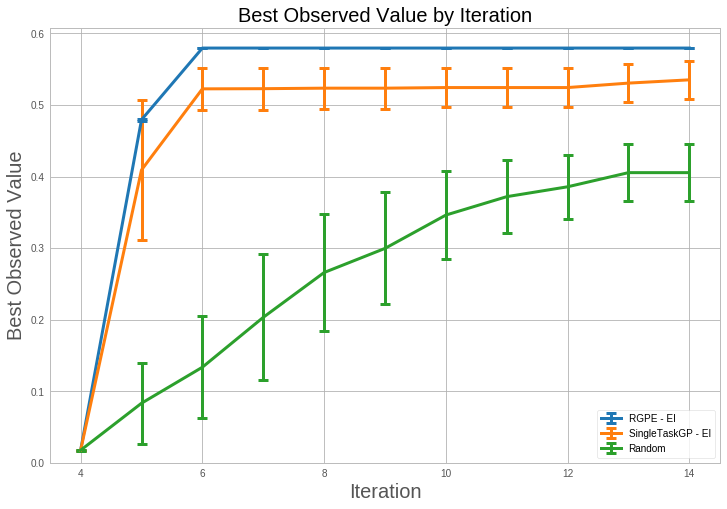

In [20]:
best_rgpe_all = torch.tensor(best_rgpe_all, dtype=dtype, device=device)
best_random_all = torch.tensor(best_random_all, dtype=dtype, device=device)
best_vanilla_ei_all = torch.tensor(best_vanilla_ei_all, dtype=dtype, device=device)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fontdict = {"size": 20}
x = range(RANDOM_INITIALIZATION_SIZE, RANDOM_INITIALIZATION_SIZE + N_BATCH + 1)
# Plot RGPE - EI
ax.errorbar(
    x, 
    best_rgpe_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_rgpe_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="RGPE - EI", 
    linewidth=3, 
    capsize=5,
    capthick=3,
)
# Plot SingleTaskGP - EI
ax.errorbar(
    x, 
   best_vanilla_ei_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_vanilla_ei_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="SingleTaskGP - EI", 
    linewidth=3,
    capsize=5,
    capthick=3,
)
# Plot Random
ax.errorbar(
    x, 
    best_random_all.mean(dim=0).cpu().numpy(), 
    yerr=(1.96*best_random_all.std(dim=0)/math.sqrt(N_TRIALS)).cpu().numpy(), 
    label="Random", 
    linewidth=3,
    capsize=5,
    capthick=3,
)
ax.set_ylim(bottom=0)
ax.set_xlabel('Iteration', fontdict=fontdict)
ax.set_ylabel('Best Observed Value', fontdict=fontdict)
ax.set_title('Best Observed Value by Iteration', fontdict=fontdict)
ax.legend(loc="lower right", fontsize=10)